In [2]:
import numpy as np
import torch
from torchvision import datasets, transforms

# Loading MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor()
])
mnist_train = datasets.MNIST(root='./data', train = True, download = True, transform = transform)

# Data Conversion 
X_train = mnist_train.data.numpy().reshape(-1,28*28).astype(np.float32)
y_train = mnist_train.targets.numpy()

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:01<00:00, 6.08MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 160kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.52MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 6.50MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Shape of X_train: (60000, 784)
Shape of y_train: (60000,)


In [3]:
np.random.seed(42)  # for reproducibility

X_sampled = []
y_sampled = []

for digit in range(10):
    idxs = np.where(y_train == digit)[0]
    chosen = np.random.choice(idxs, 100, replace=False)
    X_sampled.append(X_train[chosen])
    y_sampled.append(y_train[chosen])

X_sampled = np.vstack(X_sampled)
y_sampled = np.hstack(y_sampled)

print("Sampled X shape:", X_sampled.shape)  # Should be (1000, 784)
print("Class counts:", {i: sum(y_sampled == i) for i in range(10)})

Sampled X shape: (1000, 784)
Class counts: {0: 100, 1: 100, 2: 100, 3: 100, 4: 100, 5: 100, 6: 100, 7: 100, 8: 100, 9: 100}


In [4]:
def PCA(X, k):
    # Step 1: Center the data
    mean = np.mean(X, axis=0)
    X_centered = X - mean

    # Step 2: Covariance matrix (features x features)
    cov_matrix = np.cov(X_centered, rowvar=False)

    # Step 3: Eigen decomposition
    eig_vals, eig_vecs = np.linalg.eigh(cov_matrix)

    # Step 4: Sort eigenvalues and eigenvectors (descending order)
    sorted_indices = np.argsort(eig_vals)[::-1]
    eig_vals = eig_vals[sorted_indices]
    eig_vecs = eig_vecs[:, sorted_indices]

    # Step 5: Select top-k eigenvectors
    W = eig_vecs[:, :k]  # (784, k)

    # Step 6: Project data
    X_pca = np.dot(X_centered, W)  # (1000, k)

    return X_pca, W, mean, eig_vals

In [5]:
X_pca_500, W_500, mean_500, eig_vals_500 = PCA(X_sampled, k=500)

print("Original shape:", X_sampled.shape)
print("After PCA (k=500):", X_pca_500.shape)  # Should be (1000, 500)

Original shape: (1000, 784)
After PCA (k=500): (1000, 500)


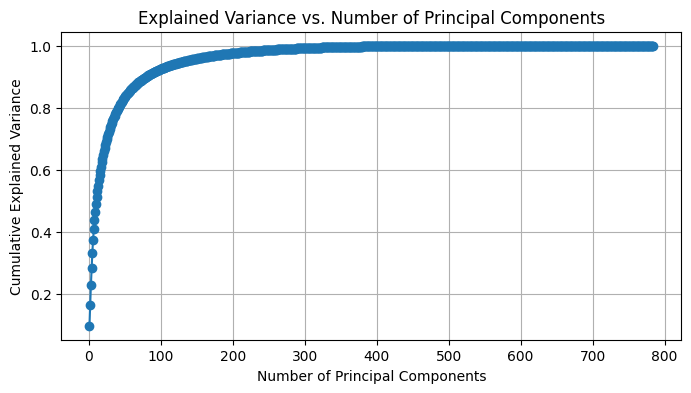

In [6]:
explained_variance_ratio = eig_vals_500 / np.sum(eig_vals_500)
cumulative_variance = np.cumsum(explained_variance_ratio)

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(np.arange(1, len(cumulative_variance)+1), cumulative_variance, marker='o')
plt.title('Explained Variance vs. Number of Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

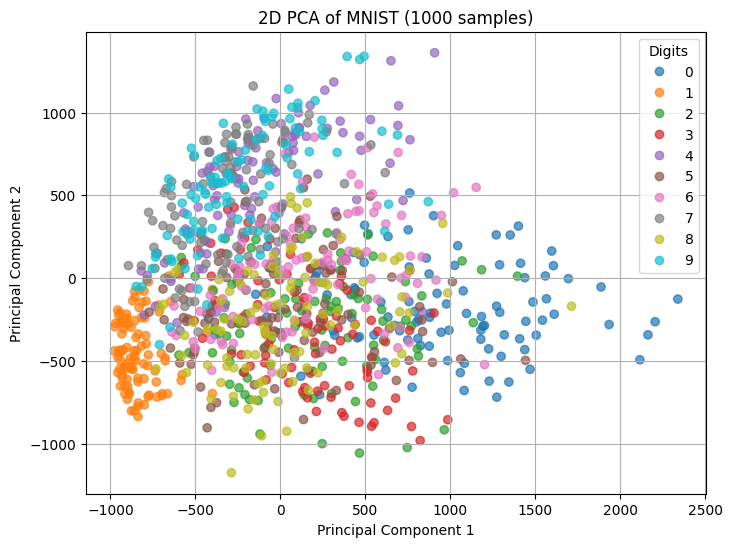

In [ ]:
X_pca_2, _, _, _ = PCA(X_sampled, k=2)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca_2[:, 0], X_pca_2[:, 1], c=y_sampled, cmap='tab10', alpha=0.7)
plt.legend(*scatter.legend_elements(), title="Digits")
plt.title("2D PCA of MNIST (1000 samples)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()

Description

In [ ]:
def reconstruct(X_pca, W, mean):
    return np.dot(X_pca, W.T) + mean  # shape: (n_samples, original_dim)

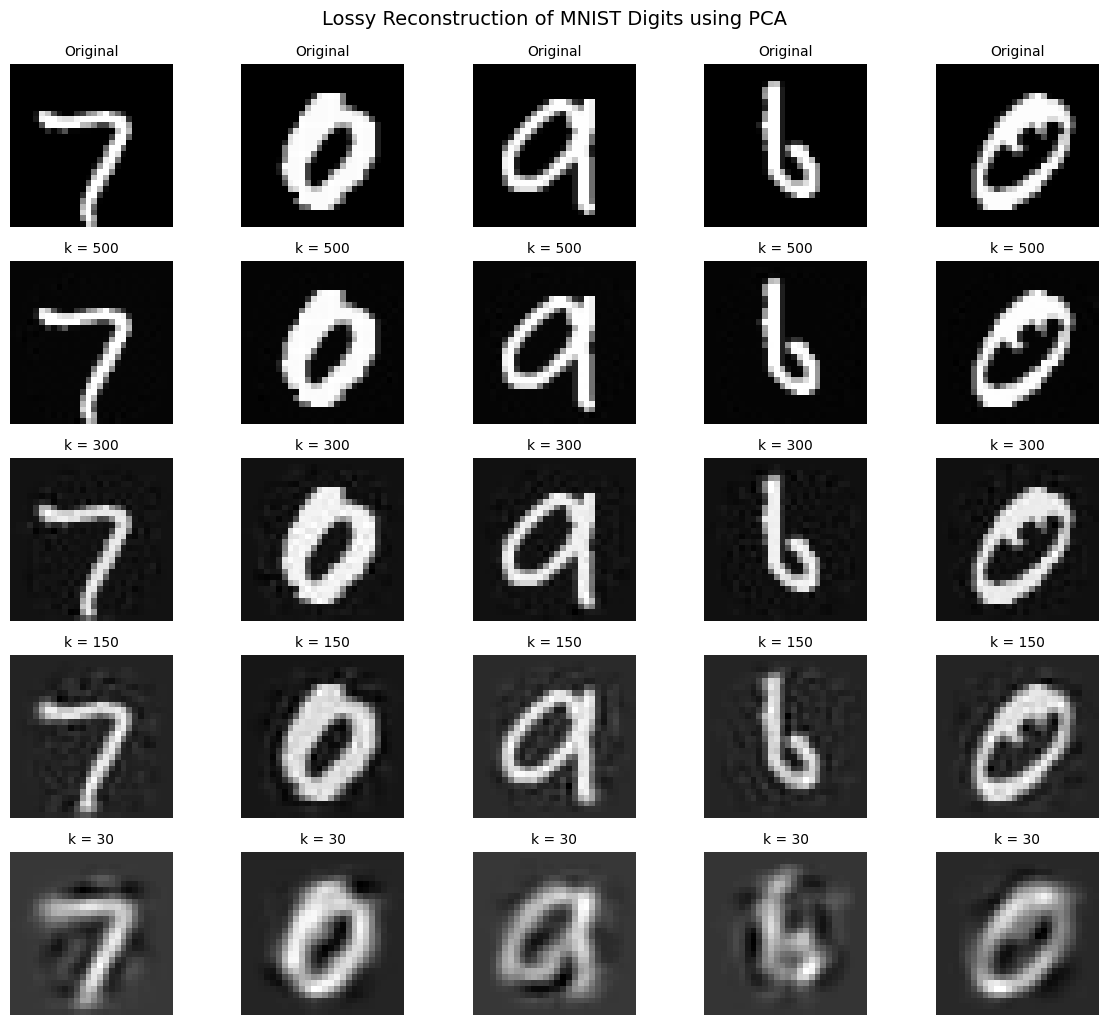

In [12]:
import matplotlib.pyplot as plt
import random
# Pick 5 random indices again if needed
indices = random.sample(range(X_sampled.shape[0]), 5)
originals = X_sampled[indices]

dims = [500, 300, 150, 30]

fig, axs = plt.subplots(len(dims)+1, 5, figsize=(12, 10))

# Plot original images
for i in range(5):
    axs[0, i].imshow(originals[i].reshape(28, 28), cmap='gray')
    axs[0, i].axis('off')
    axs[0, i].set_title("Original", fontsize=10)

# Plot reconstructions for each k
for row, k in enumerate(dims):
    X_pca_k, W_k, mean_k, _ = PCA(X_sampled, k)
    recon = reconstruct(X_pca_k[indices], W_k, mean_k)

    for col in range(5):
        axs[row+1, col].imshow(recon[col].reshape(28, 28), cmap='gray')
        axs[row+1, col].axis('off')
        axs[row+1, col].set_title(f"k = {k}", fontsize=10)

# Label the rows
for row_idx, k in enumerate(["Original"] + dims):
    axs[row_idx, 0].set_ylabel(f"{'Original' if row_idx==0 else f'k={k}'}", fontsize=12, rotation=90, labelpad=15)

plt.tight_layout()
plt.suptitle("Lossy Reconstruction of MNIST Digits using PCA", fontsize=14, y=1.02)
plt.show()

In [15]:
from sklearn.model_selection import train_test_split

train_data = datasets.MNIST (root='./data', train = True, download=True, transform = transform)
test_data = datasets.MNIST(root='./data',train = False, download = True, transform = transform)

# Get all flattened training images
X_full = train_data.data.view(-1, 28*28).numpy().astype(np.float32)
y_full = train_data.targets.numpy()

X_test = test_data.data.view(-1, 28*28).numpy().astype(np.float32)
y_test = test_data.targets.numpy()

# Normalize (important for MLP performance)
X_full /= 255.0
X_test /= 255.0

# Random 40k sample from train
X_train, _, y_train, _ = train_test_split(X_full, y_full, train_size=40000, stratify=y_full, random_state=42)

In [18]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Define a simple MLP model
mlp_raw = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=30, random_state=42)

# Train on full-dim data
mlp_raw.fit(X_train, y_train)

# Predict and evaluate
y_pred_raw = mlp_raw.predict(X_test)

print("=== Raw (784D) ===")
print("Accuracy:", accuracy_score(y_test, y_pred_raw))
print("Precision:", precision_score(y_test, y_pred_raw, average='macro'))
print("Recall:", recall_score(y_test, y_pred_raw, average='macro'))

=== Raw (784D) ===
Accuracy: 0.9783
Precision: 0.9782382544524794
Recall: 0.9780781727604125


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(


In [22]:
dims = [500, 300, 150, 30, 20 , 10]
results = {}

for k in dims:
    print(f"\n=== PCA with k={k} ===")

    # Fit PCA on X_train
    X_train_pca, W_k, mean_k, _ = PCA(X_train, k)

    # Apply same PCA to X_test
    X_test_centered = X_test - mean_k
    X_test_pca = X_test_centered @ W_k

    # Train MLP on reduced features
    mlp = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=30, random_state=42)
    mlp.fit(X_train_pca, y_train)

    # Predict
    y_pred = mlp.predict(X_test_pca)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro')
    rec = recall_score(y_test, y_pred, average='macro')

    # Store
    results[k] = {'accuracy': acc, 'precision': prec, 'recall': rec}

    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")


=== PCA with k=500 ===
Accuracy:  0.9717
Precision: 0.9716
Recall:    0.9714

=== PCA with k=300 ===


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy:  0.9720
Precision: 0.9718
Recall:    0.9718

=== PCA with k=150 ===


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy:  0.9745
Precision: 0.9744
Recall:    0.9742

=== PCA with k=30 ===


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy:  0.9769
Precision: 0.9769
Recall:    0.9765

=== PCA with k=20 ===


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy:  0.9716
Precision: 0.9714
Recall:    0.9713

=== PCA with k=10 ===
Accuracy:  0.9368
Precision: 0.9360
Recall:    0.9359


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(


In [20]:
import pandas as pd

df_results = pd.DataFrame(results).T
print("\n📊 PCA Classification Results:")
print(df_results)


📊 PCA Classification Results:
     accuracy  precision    recall
500    0.9717   0.971636  0.971440
300    0.9720   0.971781  0.971811
150    0.9745   0.974416  0.974223
30     0.9769   0.976853  0.976516


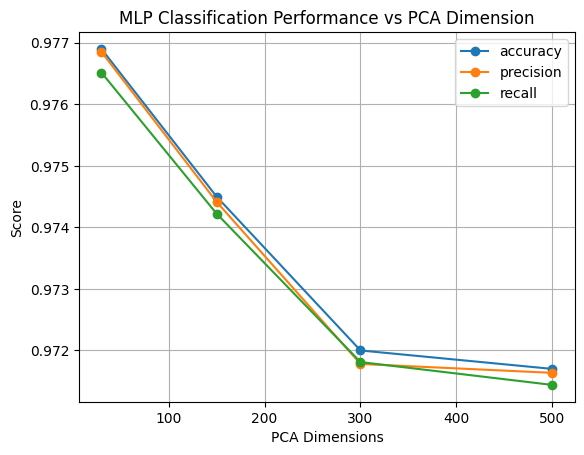

In [21]:
import matplotlib.pyplot as plt

df_results.plot(marker='o')
plt.title("MLP Classification Performance vs PCA Dimension")
plt.xlabel("PCA Dimensions")
plt.ylabel("Score")
plt.grid(True)
plt.show()